In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from utils import data_process, DrivingDataset, augment
from models import SimpleCNN
from ncps.wirings import AutoNCP 
from ncps.torch import LTC

In [2]:
# process data
data_process()

# read parquet file
train_table = pq.read_table("dataset/processed/train.parquet")
test_table = pq.read_table("dataset/processed/test.parquet")
# convert to pandas dataframe
train_df = train_table.to_pandas()
test_df = test_table.to_pandas()

# of images:  63825


In [3]:
train_df

,image,angle
0,0.jpg,0.000000
1,1.jpg,0.000000
2,2.jpg,0.000000
3,3.jpg,0.000000
4,4.jpg,0.000000
...,...,...
51055,51055.jpg,-1.310000
51056,51056.jpg,-1.310000
51057,51057.jpg,-1.310000
51058,51058.jpg,-1.310000


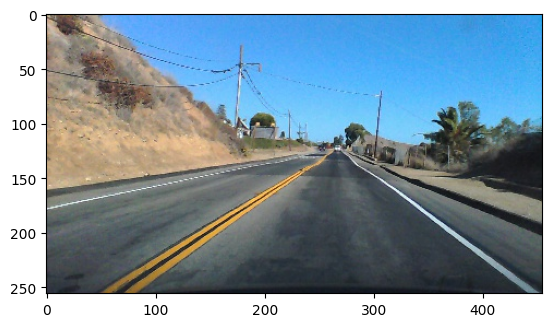

In [4]:
img_dir = "dataset/data"
sample_img = Image.open(os.path.join(img_dir, train_df["image"].iloc[12345]))
plt.imshow(sample_img)
plt.show()

In [5]:
batch_size = 8
lr = 0.001
epochs = 2
N = 10

augmentation = augment()
train_dataloader = DataLoader(DrivingDataset(N, augmentation, "train"), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(DrivingDataset(N, augmentation, "test"), batch_size=batch_size, shuffle=True)


In [6]:
feature_extractor = SimpleCNN()

in_features = 1 # extracted feature from CNN
out_features = 1 # steering angle
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron
ltc_model = LTC(in_features, wiring, batch_first=True)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
ltc_optimizer = torch.optim.Adam(ltc_model.parameters(), lr=lr)

/home/sam/anaconda3/envs/angle/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# Train
for epoch in range(epochs):
    # training
    ltc_model.train()
    loss = 0.0
    count = 0
    for i, (img, angle) in tqdm(enumerate(train_dataloader), desc="Training...", total=len(train_dataloader)):
        img = img.to(device) # (B,N,C,H,W)
        C, H, W = img.shape[-3:]
        img = img.view(-1, C, H, W) # (B*N,C,H,W)

        angle = angle.to(device) # (B,N)
        angle = angle.view(-1, 1) # (B*N,1)

        # Feature Extraction
        features = feature_extractor(img) # (B*N,1)
        features = features.view(-1, N, 1) # (B,N,1)

        # NCP
        ltc_optimizer.zero_grad()
        pred_angle, hx = ltc_model(features) # (B,N,1)
        pred_angle = pred_angle.view(-1, 1) # (B*N,1)

        loss = criterion(pred_angle, angle)
        loss.backward()
        ltc_optimizer.step()
        loss += loss.item()
        count += 1
        if i % 10 == 0:
            print(f"Epoch {epoch}, Training Loss {loss / count:.4f}")
    # validation
    ltc_model.eval()
    loss = 0.0
    count = 0
    with torch.no_grad():
        for i, (img, angle) in tqdm(enumerate(test_dataloader), desc="Testing...", total=len(test_dataloader)):
            img = img.to(device)
            img = img.view(-1, C, H, W)
            angle = angle.to(device)
            angle = angle.view(-1, 1)

            features = feature_extractor(img) # (B*N,1)
            features = features.view(-1, N, 1) # (B,N,1)

            pred_angle, hx = ltc_model(features) # (B,N,1)
            pred_angle = pred_angle.view(-1, 1) # (B*N,1)
            
            loss = criterion(pred_angle, angle)
            loss += loss.item()
            count += 1
    print(f"Epoch {epoch}, Testing Loss {loss / count:.4f}")


In [9]:
# Check steering angle prediction

sample = next(iter(test_dataloader))
img, angle = sample
print("image shape:", img.shape, "angle shape:", angle.shape) # (B,N,C,H,W), (B,N)
C, H, W = img.shape[-3:]
img = img.view(-1, C, H, W)
img = img.to(device)
angle = angle.to(device)
angle = angle.view(-1, 1)

features = feature_extractor(img) # (B*N,1)
features = features.view(-1, N, 1) # (B,N,1)
pred_angle, hx = ltc_model(features) # (B,N,1)
pred_angle = pred_angle.view(-1, 1) # (B*N,1)

# stack predicted angle and ground truth angle
pred_angle = pred_angle.squeeze()
angle = angle.squeeze()
results = torch.stack([pred_angle, angle], dim=1) # (B*N,2)
print(f"predicted angle vs. ground truth angle:\n{results}")

image shape: torch.Size([8, 10, 3, 256, 455]) angle shape: torch.Size([8, 10])
predicted angle vs. ground truth angle:
tensor([[  0.1896,   4.2400],
        [  0.3615,   4.1300],
        [  0.4754,   3.7300],
        [  0.5372,   3.4300],
        [  0.5673,   3.1300],
        [  0.5810,   2.9200],
        [  0.5870,   2.7200],
        [  0.5895,   2.6200],
        [  0.5905,   1.9200],
        [  0.5909,   1.3100],
        [  0.1896,  -9.0800],
        [  0.3614,  -9.0800],
        [  0.4754,  -9.1800],
        [  0.5371,  -9.1800],
        [  0.5671,  -9.1800],
        [  0.5808,  -9.1800],
        [  0.5868,   0.0000],
        [  0.5893,  -9.9800],
        [  0.5904, -10.3900],
        [  0.5908, -10.8900],
        [  0.1896,  18.0500],
        [  0.3615,  18.0500],
        [  0.4755,  18.1500],
        [  0.5372,  18.6600],
        [  0.5674,  18.9600],
        [  0.5811,  18.9600],
        [  0.5870,  19.1600],
        [  0.5895,  19.4600],
        [  0.5905,  19.4600],
        [  